# Final Portfolio Project - Codecademy Data Science
As part of the final portfolio project for the Codecademy data science career path, I will be using a dataset from Kaggle containing information on residential homes in Ames, Iowa. The aim of the project will be to predict the final price of each home. The dataset contains 79 explanatory variables describing nearly all aspects of a home.

**Project Scope**
1. Load in the data
2. Preprocess data
3. EDA
4. Modelling


## Import Modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
import scipy.stats as st
import warnings
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

warnings.simplefilter(action='ignore', category=FutureWarning)
jtplot.style(theme='onedork', context='notebook', grid=False, ticks=True, figsize=(10, 5))

## Load Data
Kaggle provides two datasets `train.csv` and `test.csv`. The test data is the same as the train data however the test data doesn't have a `SalePrice` column. For now I will focus on the data in `train.csv`. `data_description.txt` provides info on what each column represents that we can reference throughout the project.

In [3]:
df = pd.read_csv('train.csv')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 81)

In [5]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Text(0.5, 0, 'Columns')

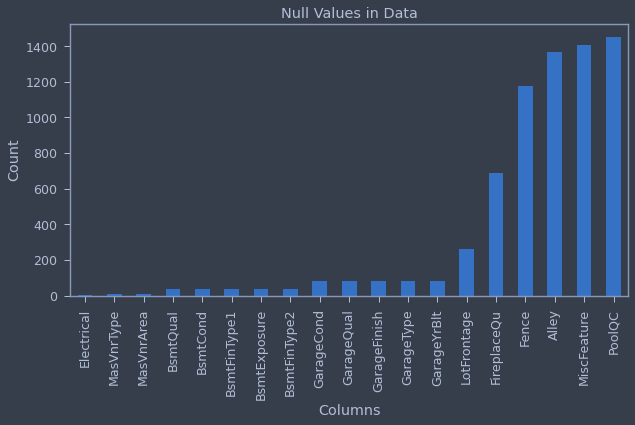

In [6]:
null_cols = df.columns[df.isnull().any()]
df[null_cols].isnull().sum().sort_values().plot.bar()
plt.title('Null Values in Data')
plt.ylabel('Count')
plt.xlabel('Columns')

Now we have loaded in the data, we have been able to get an initial look at what the dataset contains. The dataset has 1460 entries and 81 columns, the columns hold multiple data types ranging from integers, floats and text.

We can also see there are 19 columns with null values. `PoolQC`, `MiscFeature`, `Alley` and `Fence` have the most null values, with nearly all entries missing these values. Looking in `data_description.txt` we can see that the null values don't necassarily mean missing data. For example, `PoolQC` NA stands for 'No Pool'. This is the same for `MiscFeature`, `Alley` and `Fence` which explains the high number of null values.

## Preprocess Data
Now we have loaded the data and got a better understanding of what it is saying we need to preprocess the data for use later.

Text(0.5, 0, 'Living Area (sqft)')

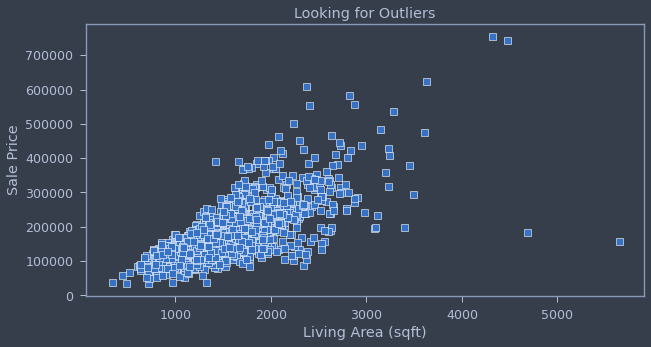

In [7]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', marker='s')
plt.title('Looking for Outliers')
plt.ylabel('Sale Price')
plt.xlabel('Living Area (sqft)')

The above chart of Living Area to Sale Price allows us to see any outliers in the data. We can see that there are 4 outliers above 4000 sqft, where the properties sold for either an unusually high or low amount. Our first task then is to remove any properties that have a living area above 4000 sqft.

In [8]:
df = df[df['GrLivArea'] < 4000]

We now want to take the log of the sale price so that errors in predicting cheap houses will effect the result in the same way as errors in prediciting expensive houses.

In [9]:
df.SalePrice = np.log1p(df.SalePrice)

We now need to take care of all the null values we found when we loaded the data. A lot of theses null values actually meant the house did not have the given feature.

In [10]:
# Alley - NA means 'no alley access'
df.loc[:, 'Alley'] = df.loc[:, 'Alley'].fillna('None')

# BedroomAbvGr - NA means 0 (Assumption)
df.loc[:, 'BedroomAbvGr'] = df.loc[:, 'BedroomAbvGr'].fillna(0)

# BsmtQual etc - NA for any basement features means 'no basement'
df.loc[:, 'BsmtQual'] = df.loc[:, 'BsmtQual'].fillna('No')
df.loc[:, 'BsmtCond'] = df.loc[:, 'BsmtCond'].fillna('No')
df.loc[:, 'BsmtExposure'] = df.loc[:, 'BsmtExposure'].fillna('No')
df.loc[:, 'BsmtFinType1'] = df.loc[:, 'BsmtFinType1'].fillna('No')
df.loc[:, 'BsmtFinType2'] = df.loc[:, 'BsmtFinType2'].fillna('No')
df.loc[:, 'BsmtFullBath'] = df.loc[:, 'BsmtFullBath'].fillna(0)
df.loc[:, 'BsmtHalfBath'] = df.loc[:, 'BsmtHalfBath'].fillna(0)
df.loc[:, 'BsmtUnSF'] = df.loc[:, 'BsmtUnfSF'].fillna(0)

# CentralAir - NA means No (Assumption)
df.loc[:, 'CentralAir'] = df.loc[:, 'CentralAir'].fillna('N')

# Condition - NA means normal (Assumption)
df.loc[:, 'Condition1'] = df.loc[:, 'Condition1'].fillna('Norm')
df.loc[:, 'Condition2'] = df.loc[:, 'Condition2'].fillna('Norm')

# EnclosedPorch - NA means no porch (Assumption)
df.loc[:, 'EnclosedPorch'] = df.loc[:, 'EnclosedPorch'].fillna(0)

# External - NA means average (Assumption)
df.loc[:, 'ExterCond'] = df.loc[:, 'ExterCond'].fillna('TA')
df.loc[:, 'ExterrQual'] = df.loc[:, 'ExterQual'].fillna('TA')

# Fence - NA means 'no fence' 
df.loc[:, 'Fence'] = df.loc[:, 'Fence'].fillna('No')

# Fireplace - NA means 'no fireplace'
df.loc[:, 'FireplaceQu'] = df.loc[:, 'FireplaceQu'].fillna('No')
df.loc[:, 'Fireplaces'] = df.loc[:, 'Fireplaces'].fillna(0)

# Functional - NA means 'typical'
df.loc[:, 'Functional'] = df.loc[:, 'Functional'].fillna('Typ')

# Garage - NA means 'no garage'
df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)

# HalfBath - NA means no half baths (Assumption)
df.loc[:, 'HalfBath'] = df.loc[:, 'HalfBath'].fillna(0)

# HeatingQC - NA means typical (Assumption)
df.loc[:, 'HeatingQC'] = df.loc[:, 'HeatingQC'].fillna('TA')

# KitchenAbvGr - NA means 0 (Assumption)
df.loc[:, 'KitchenAbvGr'] = df.loc[:, 'KitchenAbvGr'].fillna(0)

# KitchenQual - NA means typical (Assumption)
df.loc[:, 'KitchenQual'] = df.loc[:, 'KitchenQual'].fillna('TA')

# LotFrontage - NA means no lot frontage (Assumption)
df.loc[:, 'LotFrontage'] = df.loc[:, 'LotFrontage'].fillna(0)

# LotShape - NA means regular (Assumption)
df.loc[:, 'LotShape'] = df.loc[:, 'LotShape'].fillna('Reg')

# MasVnrType - NA means no veneer (Assumption)
df.loc[:, 'MasVnrType'] = df.loc[:, 'MasVnrType'].fillna('None')
df.loc[:, 'MasVnrArea'] = df.loc[:, 'MasVnrArea'].fillna(0)

# MiscFeature - NA means 'no misc feature'
df.loc[:, 'MiscFeature'] = df.loc[:, 'MiscFeature'].fillna('No')
df.loc[:, 'MiscVal'] = df.loc[:, 'MiscVal'].fillna(0)

# OpenPorchSF - NA means no porch (Assumption)
df.loc[:, 'OpenPorchSF'] = df.loc[:, 'OpenPorchSF'].fillna(0)

# PavedDrive - NA means not paved (Assumption)
df.loc[:, 'PavedDrive'] = df.loc[:, 'PavedDrive'].fillna('N')

# PoolQC - NA means 'no pool'
df.loc[:, 'PoolQC'] = df.loc[:, 'PoolQC'].fillna('No')
df.loc[:, 'PoolArea'] = df.loc[:, 'PoolArea'].fillna(0)

# SaleCondition - NA means normal sale (Assumption)
df.loc[:, 'SaleCondition'] = df.loc[:, 'SaleCondition'].fillna('Normal')

# ScreenPorch - NA means no screen porch (Assumption)
df.loc[:, 'ScreenPorch'] = df.loc[:, 'ScreenPorch'].fillna(0)

# TotRmsAbvGrd - NA means 0 (Assumption)
df.loc[:, 'TotRmsAbvGrd'] = df.loc[:, 'TotRmsAbvGrd'].fillna(0)

# Utitilities - NA means all public utilities (Assumption)
df.loc[:, 'Utilities'] = df.loc[:, 'Utilities'].fillna('AllPub')

# WoodDeckSF - NA means no wood deck (Assumption)
df.loc[:, 'WoodDeckSF'] = df.loc[:, 'WoodDeckSF'].fillna(0)

All the null values have now been taken care of, we have had to make assumptions about what some null values mean as there is no information given in `data_description.txt`. We can now encode the data for some of the numerical and categorical features. 

### Categorical Features
Some categorical features can be encoded as ordered numbers.

- `Alley` - Type of alley access to property. Will be encoded as 1 - 2.
- `BsmtCond` - Evaluates the general condition of the basement on a scale from excellent to poor. Will be encoded on a scale of 0 - 5.
- `BsmtExposure` - Refers to walkout or garden level walls on a scale from good to none. Will be encoded on a scale from 0 - 3.
- `BsmtFinType1` - Rating of basement finished area on a scale from good to unfurnished. Will be encoded on a scale from 0 - 4.
- `BsmtFinType2` - Rating of basement finished area (if multiple types) on a scale from good to unfurnished. Will be encoded on a scale from 0 - 4.
- `BsmtQual` - Evaluates the height of the basement on a scale from excellent to poor. Will be encoded on a scale from 0 - 5.
- `ExterCond` - Evaluates the present condition of the material on the exterior on scale from excellent to poor. Will be encoded on a scale from 1 - 5. 
- `ExterQual` - Evaluates the quality of the material on the exterior on a scale from excellent to poor. Will be encoded on a scale from 1 - 5.
- `FireplaceQu` - Fireplace quality on a scale excellent to poor. Will be encoded on a scale from 0 - 5.
- `Functional` - Home functionality (Assume typical unless deductions are warranted) on a scale from typical to salvage. Will be encoded on a scale from 1 - 5.
- `GarageCond` - Garage condition on a scale from excellent to poor. Will be encoded on a scale from 0 - 5.
- `GarageQual` - Garage quality on a scale from excellent to poor. Will be encoded on a scale from 0 - 5.
- `HeatingQC` - Heating quality and condition on a scale from excellent to poor. Will be encoded on a scale from 1 - 5.
- `KitchenQual` Kitchen quality on a scale from exellent to poor. Will be encoded on a scale from 1 - 5.
- `LandSlope` - Slope of property on a scale from gentle to severe. Will be encoded on a scale from 1 - 3.
- `LotShape` General shape of property on a scale from regular to irregular. Will be encoded on a scale from 1 - 4.
- `PavedDrive` - Paved driveway on a scale from paved to dirt/gravel. Will be encoded on a scale from 0 - 2.
- `PoolQC` - Pool condition and quality on a scale from excellent to fair. Will be encoded on a scale from 1 - 4.
- `Street` - Type of street on scale from gravel to paved. Will be encoded on a scale from 1 - 2.
- `Utilities` - Type of utilities available on a scale from all public to electricity only. Will be encoded on a scale from 1 - 4.

In [11]:
df = df.replace({"Alley" : {'None': 0, "Grvl" : 1, "Pave" : 2},
                 "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                 "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                 "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                 "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                 "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                 "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                 "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                 "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                 "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                 "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                 "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                 "Street" : {"Grvl" : 1, "Pave" : 2},
                 "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}})

We have now encoded the numerical and categorical variables, this will allow our machine learning algorithms to work better with the data. We now want to create new features in 2 different ways:

- We will simplify some of the existing variables
- We will combine some of the existing variables

### Simplify Existing Variables
The variables describing the condition of various features of the property are done so using scale that can be simplified.

- `OverallQual` - Given on a scale from 1 - 10. Will be simplified to a scale from 1 - 3.
- `OverallCond` - Given on a scale from 1 - 10. Will be simplified to a scale from 1 - 3.
- `PoolQC` - Given on a scale from 1 - 4. Will be simplified to a scale from 1 - 2.
- `GarageCond` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `GarageQual` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `FirePlaceQu` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `Functional` - Given on a scale from 1 - 8. Will be simplified to a scale from 1 - 4.
- `HeatingQC` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `BsmtFinType1` - Given on a scale from 1 - 6. Will be simplified to a scale from 1 - 2.
- `BsmtFinType2` - Given on a scale from 1 - 6. Will be simplified to a scale from 1 - 2.
- `BsmtCond` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `BsmtQual` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `ExterCond` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `ExterQual` - Given on a scale from 1 - 5. Will be simplified to a scale from 1 - 2.
- `MasVnrType` - Simplified to `HasMsnVnr`.
- `SaleCondition` - Simplified to `BoughtOffPlan`.

In [12]:
df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
df["SimplGarageCond"] = df.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplGarageQual"] = df.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
df["SimplBsmtCond"] = df.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplBsmtQual"] = df.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplExterCond"] = df.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df["SimplExterQual"] = df.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
df['HasMsnVnr'] = df.MasVnrType.replace({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0})
df['BoughOffPlan'] = df.SaleCondition.replace({'Abnorml': 0, 'Alloca': 0, 'AdjLand': 0, 'Family': 0, 'Normal': 0, 'Partial': 1})

### Combining Exisiting Features
A lot of the variables offer multiple scores that could be combined. E.g. those that give a condition and a quality.

- `OverallQual` and `OverallCond` combined to give `OverallGrade`
- `GarageQual` and `GarageCond` combinded to give `GarageGrade`
- `ExterQual` and `ExteriorCond` combined to give `ExterGrade`
- `KitchenAbvGr` and `KitchenQual` combined to give `KitchenScore`
- `Fireplaces` and `FireplaceQu` combined to give `FireplaceScore`
- `GarageArea` and `GarageQual` combined to give `GarageScore`
- `PoolArea` and `PoolQC` combined to give `PoolScore`
- `SimplOverallQual` and `SimplOverallCond` combined to give `SimplOverallGrade`
- `SimplExterQual` and `SimplExteriorCond` combined to give `SimplExterGrade`
- `PoolArea` and `SimplPoolQC` combined to give `SimplPoolScore`
- `GarageArea` and `SimplGarageQual` combined to give `SimplGarageScore`
- `Fireplaces` and `SimplFireplaceQu` combined to give `SimplFireplaceScore`
- `KitchenAbvGr` and `SimplKitchenQual` combined to give `SimplKitchenScore`
- `BsmtFullBath`, `BsmtHalfBath, `FullBath` and `HalfBath combined to give `FullBath`
- `1stFlrSF` and `2ndFlrSF` combined to give `AllFlrSF`
- `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch` and `ScreenPorch` combined to give `AllPorcchSF`

In [13]:
df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]
df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]
df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]
df["GarageScore"] = df["GarageArea"] * df["GarageQual"]
df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
df["SimplOverallGrade"] = df["SimplOverallQual"] * df["SimplOverallCond"]
df["SimplExterGrade"] = df["SimplExterQual"] * df["SimplExterCond"]
df["SimplPoolScore"] = df["PoolArea"] * df["SimplPoolQC"]
df["SimplGarageScore"] = df["GarageArea"] * df["SimplGarageQual"]
df["SimplFireplaceScore"] = df["Fireplaces"] * df["SimplFireplaceQu"]
df["SimplKitchenScore"] = df["KitchenAbvGr"] * df["SimplKitchenQual"]
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + df["FullBath"] + (0.5 * df["HalfBath"])
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

In [14]:
# Split features into numerical and categorical
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(exclude=['object']).columns
numerical_features = numerical_features.drop('SalePrice')
df_num = df[numerical_features]
df_cat = df[categorical_features]

In [15]:
# Remaining missing values for numerical features replaced with median
df_num = df_num.fillna(df_num.median())

In [16]:
# To lessen impact of outliers, numerical features will be log transformed when their skewness is > 0.5
skewness = df_num.apply(lambda x: st.skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
df_num[skewed_features] = np.log1p(df_num[skewed_features])

In [17]:
# Create dummy features for categorical values via one-hot encoding
df_cat = pd.get_dummies(df_cat)

We have now finished preprocessing the data and are ready to do some EDA to gain some insights into what variables in a property affect its sale price.

## EDA
We are now at point where we can start to perform exploratory data analysis on our dataset. This is where we can gain some real insights into what variables affect sale price and give us an idea of what features we may want to include in our model.

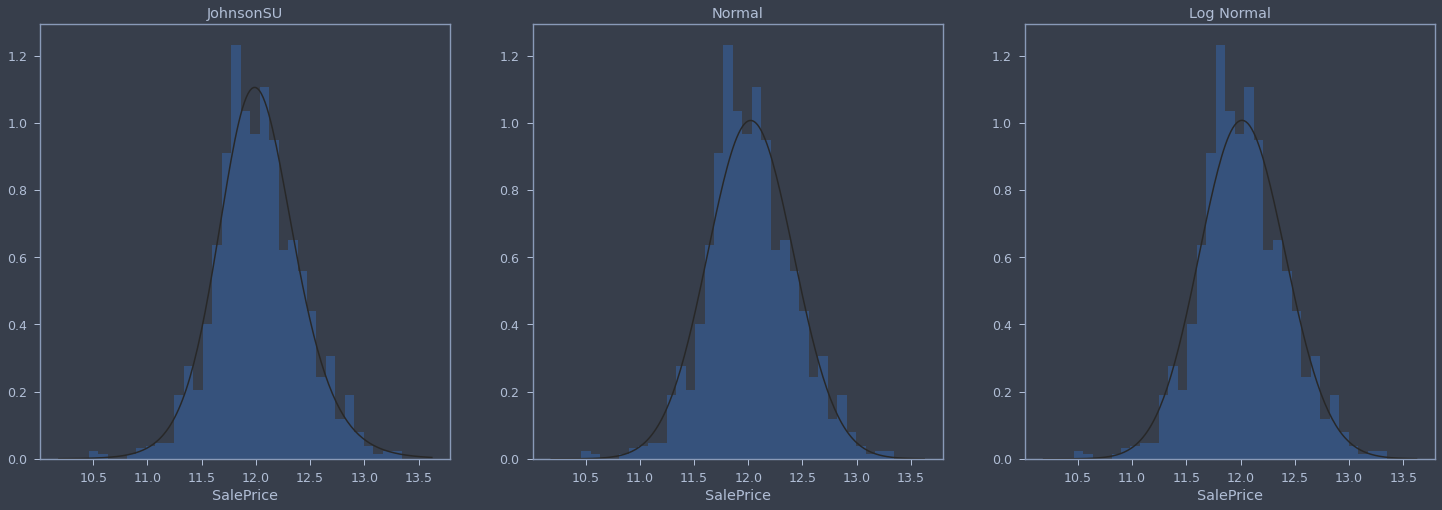

In [18]:
f, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.distplot(df['SalePrice'], kde=False, fit=st.johnsonsu, ax=ax[0])
sns.distplot(df['SalePrice'], kde=False, fit=st.norm, ax=ax[1])
sns.distplot(df['SalePrice'], kde=False, fit=st.lognorm, ax=ax[2])
ax[0].title.set_text('JohnsonSU')
ax[1].title.set_text('Normal')
ax[2].title.set_text('Log Normal')

We can see above that after removing the outliers from the data, it now follows an approximatley normal distribution. An unbounded Johnson distribution is the best fit for the data.

In [19]:
quantitative = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 
                'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MSSubClass', 'MoSold', 'OpenPorchSF', 'OverallCond', 
                'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
qualitative = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 
               'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 
               'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 
               'Utilities']

#### Quantitative Variables

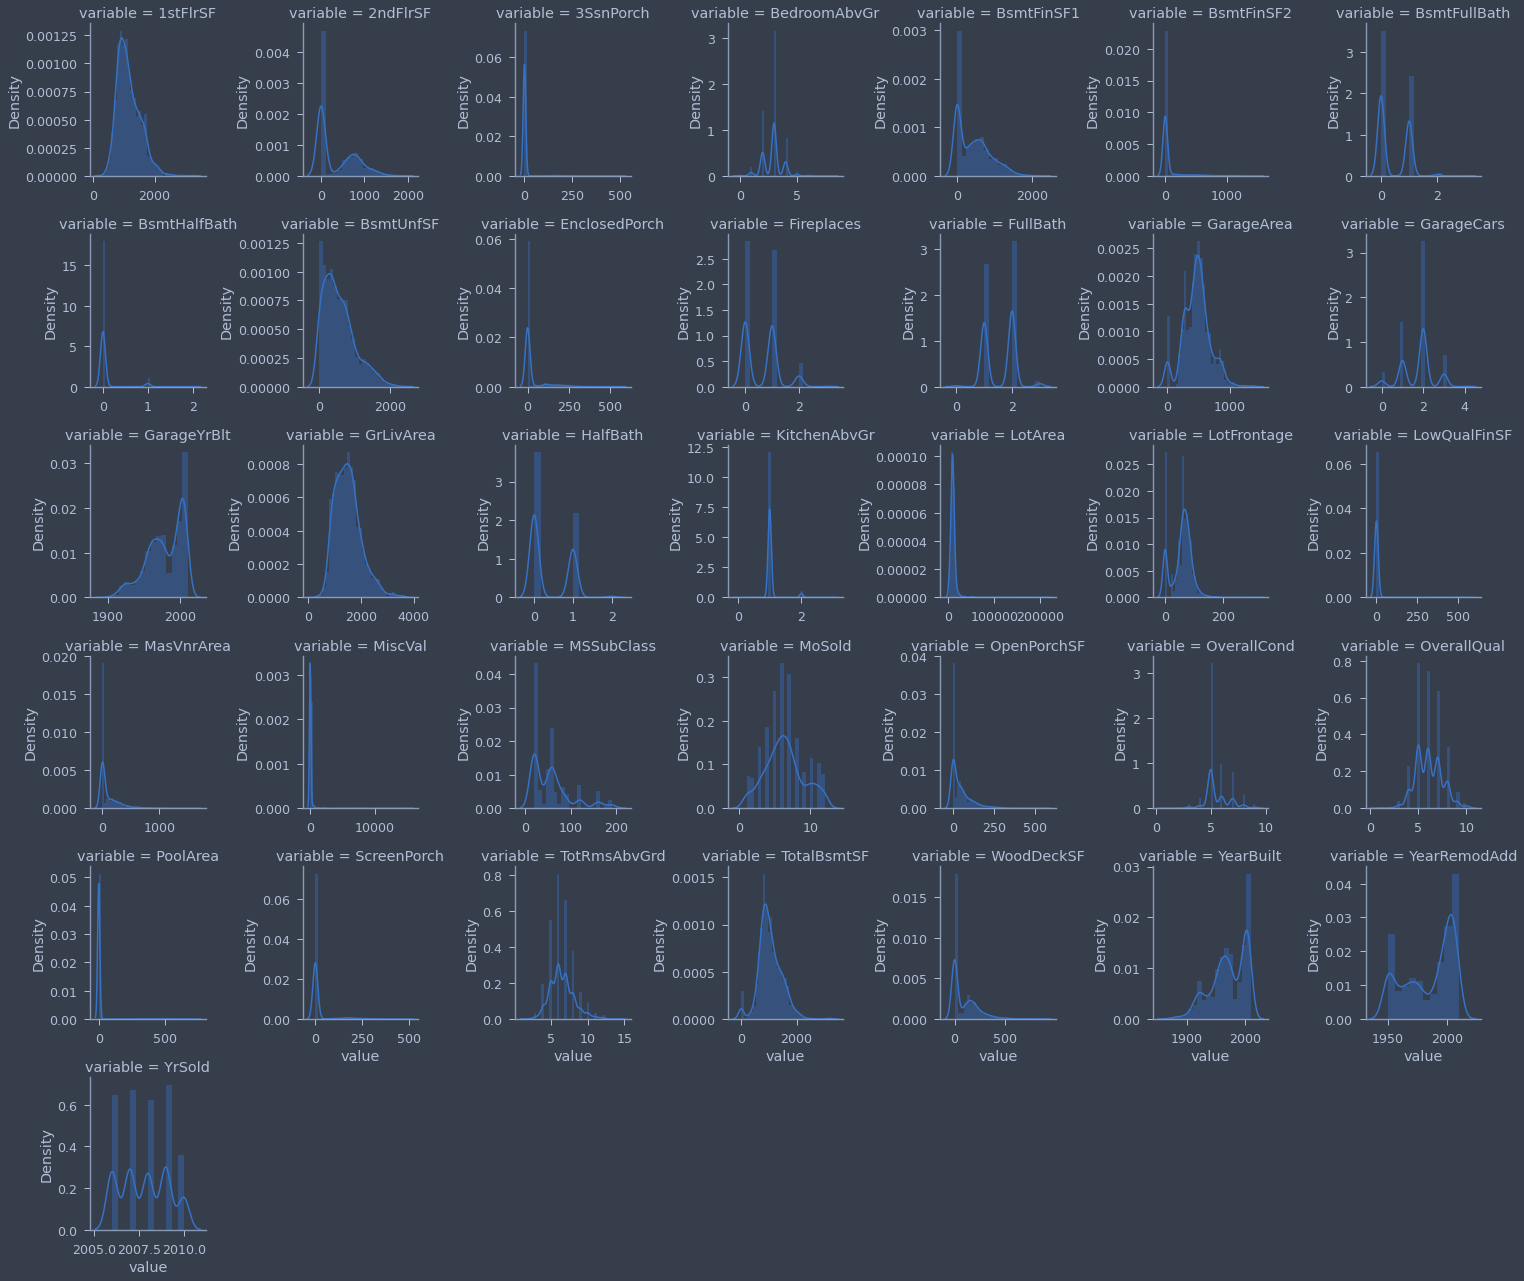

In [20]:
f = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(f, col='variable', col_wrap=7, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

#### Qualitative Variables

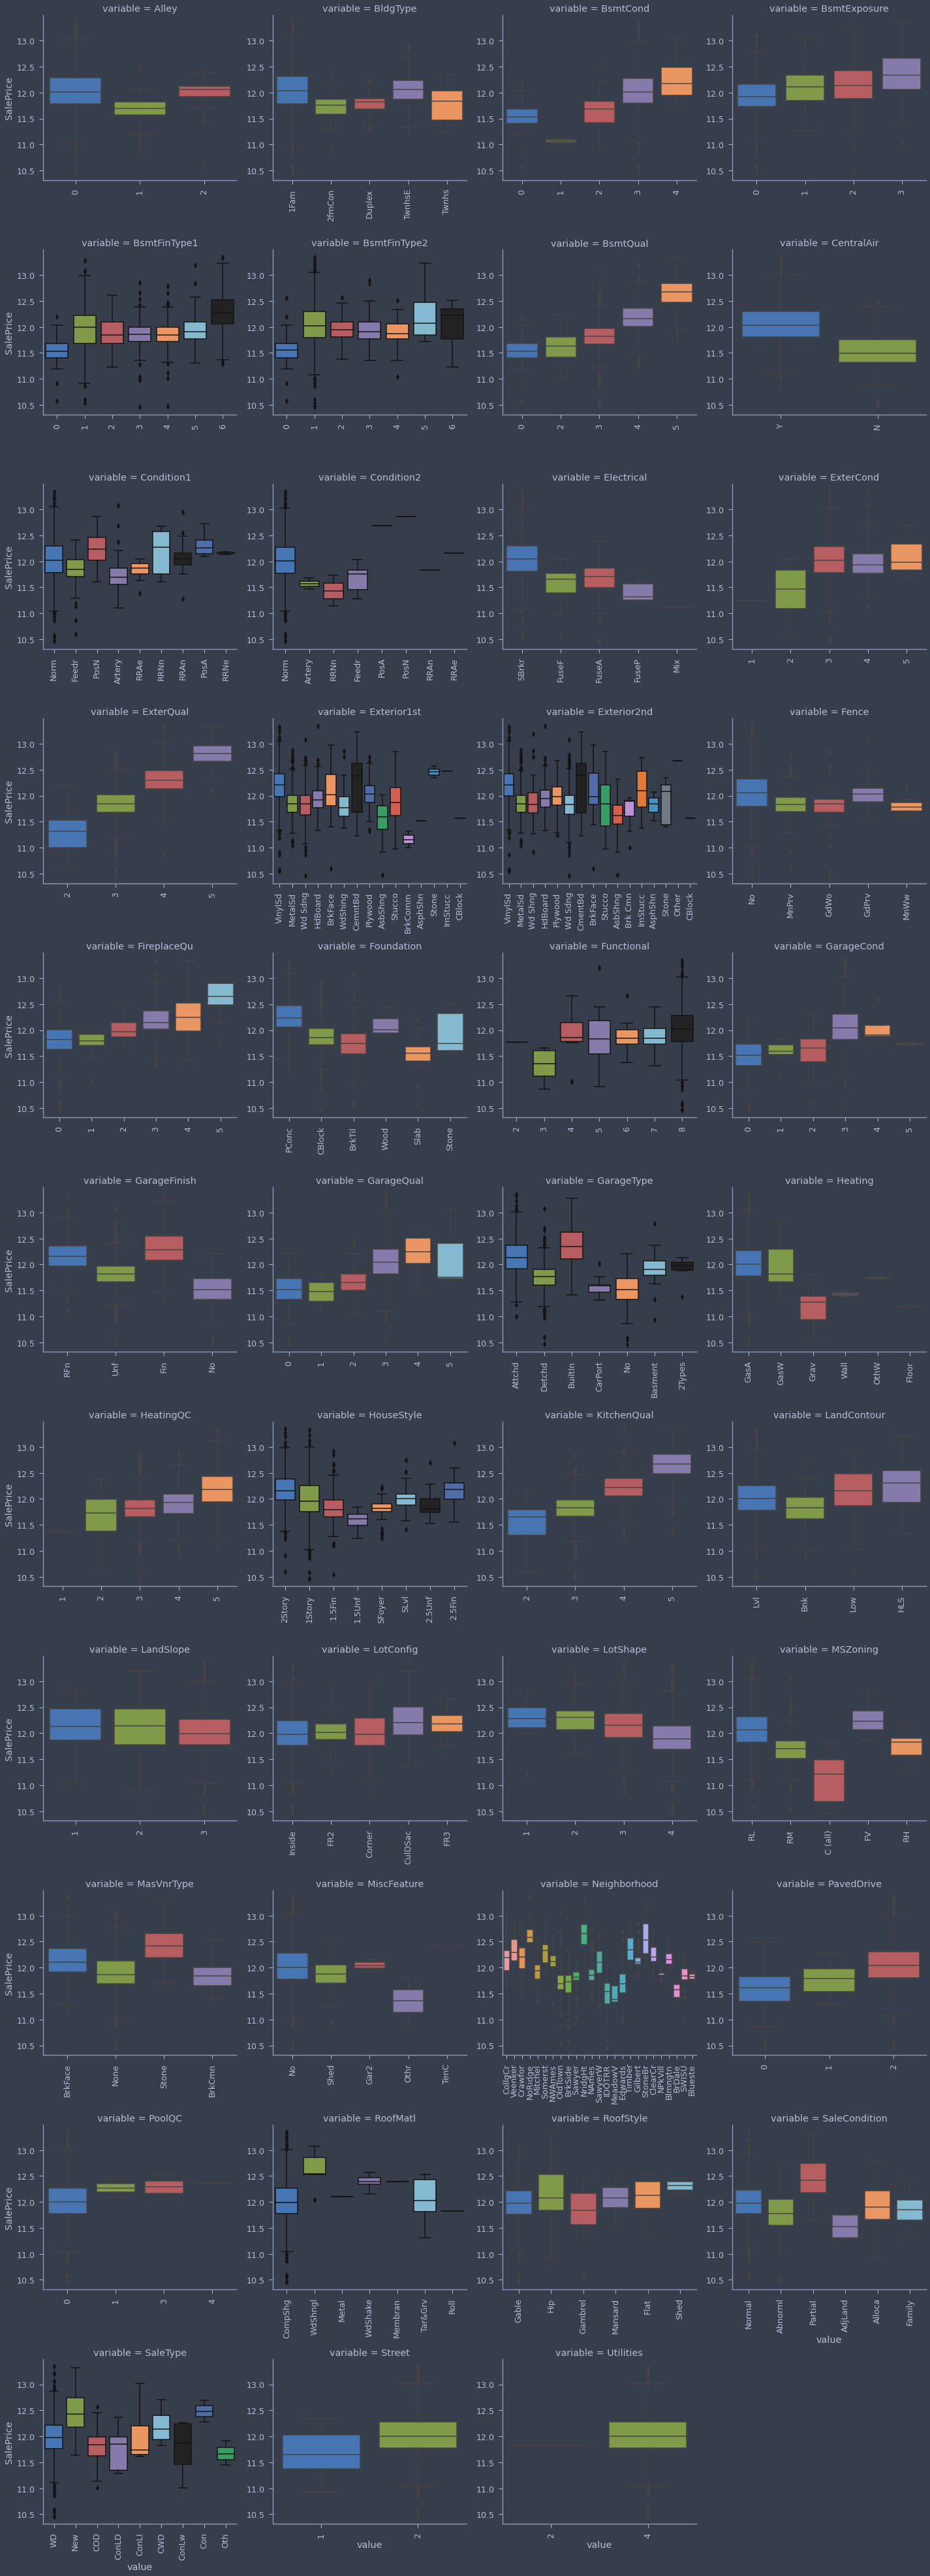

In [21]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False, height=5)
g = g.map(boxplot, 'value', 'SalePrice')

We can see that some variables provide a lot of variation in `SalePrice`. `Neighborhood`, `BsmtQual`, `GarageType` and `MSZoning` seem to have a large effect on sale price. A `Partial` `SaleCondition` also seems to affect the `SalePrice` more than the other options. `RoofType`, `LotConfig` and `RoofStyle` don't seem to have much affect on the sale price with quite an even distribution across the boxplots. 

/home/alexwilson/miniconda3/envs/myenv/lib/python3.9/site-packages/scipy/stats/stats.py:3680: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


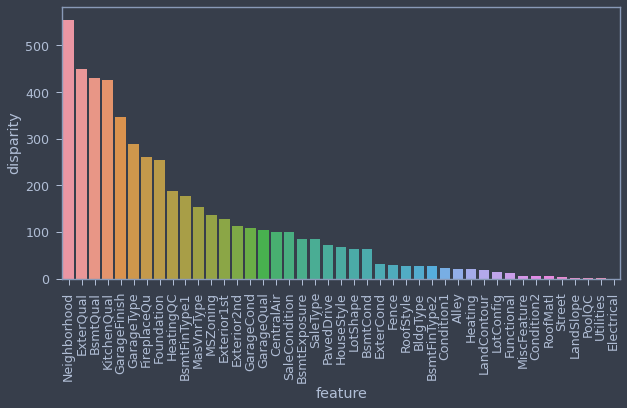

In [22]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

The chart above shows an estimation of the influence of the categorical variables on sale price. For each variable, the `SalePrice` is partitioned into distinct sets based on the category value. An ANOVA test is then used to test if sets have similar distributions. If a variable has a minor impact then the set mean should be equal and therefore the disparity less. As we can see, `Neighborhood` seems to have the greatest impact on sale price of the qualitative variables.

In [23]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['Alley_E', 'BldgType_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'BsmtQual_E', 'CentralAir_E', 'Condition1_E', 'Condition2_E', 'Electrical_E', 'ExterCond_E', 'ExterQual_E', 'Exterior1st_E', 'Exterior2nd_E', 'Fence_E', 'FireplaceQu_E', 'Foundation_E', 'Functional_E', 'GarageCond_E', 'GarageFinish_E', 'GarageQual_E', 'GarageType_E', 'Heating_E', 'HeatingQC_E', 'HouseStyle_E', 'KitchenQual_E', 'LandContour_E', 'LandSlope_E', 'LotConfig_E', 'LotShape_E', 'MSZoning_E', 'MasVnrType_E', 'MiscFeature_E', 'Neighborhood_E', 'PavedDrive_E', 'PoolQC_E', 'RoofMatl_E', 'RoofStyle_E', 'SaleCondition_E', 'SaleType_E', 'Street_E', 'Utilities_E']


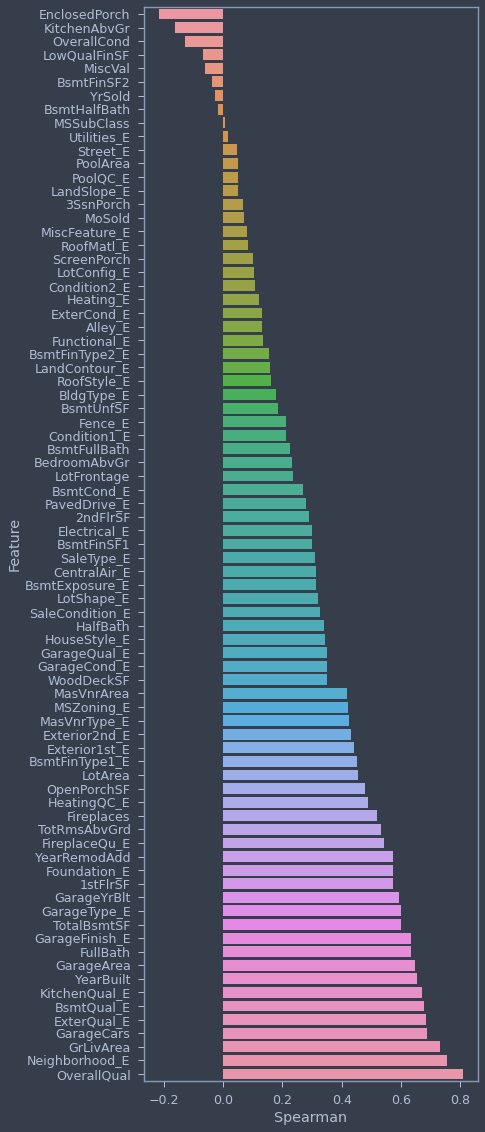

In [24]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['Feature'] = features
    spr['Spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('Spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='Feature', x='Spearman', orient='h')

features = quantitative + qual_encoded
spearman(df, features)

The correlations of the variables to `SalePrice` are important, as when we build our model we want to include only those variables that affect sale price the most. We can see above that `OverallQual` is the main criteria for `SalePrice`.

## Modelling
We will now perform a linear regression on the data to see if we can accurately predict house prices based on the various features.

In [25]:
# Join categorical and numerical features
df_mdl = pd.concat([df_num, df_cat], axis=1)

# Partition dataset into training and test set
df.SalePrice = np.log1p(df.SalePrice)
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(df_mdl, y, test_size=0.3, random_state=0)

print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_train: ' + str(y_train.shape))
print('y_test: '+ str(y_test.shape))

X_train: (1019, 268)
X_test: (437, 268)
y_train: (1019,)
y_test: (437,)


In [26]:
# Standardise numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.fit_transform(X_test.loc[:, numerical_features])

/home/alexwilson/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/alexwilson/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
# Define error measure for official scoring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
    return rmse

def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring=scorer, cv=10))
    return rmse

#### 1* Linear Regression without regularisation

RMSE on Training set : 3771773.378241991
RMSE on Test set : 1340696386.6706686


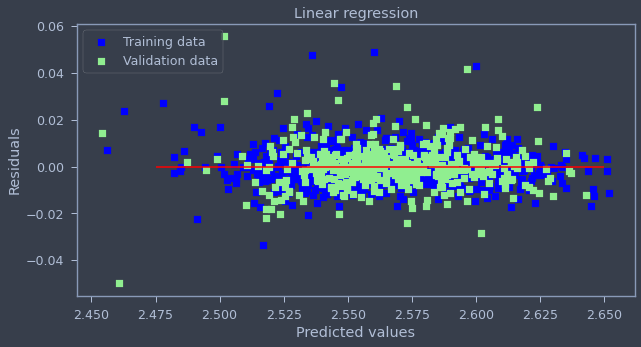

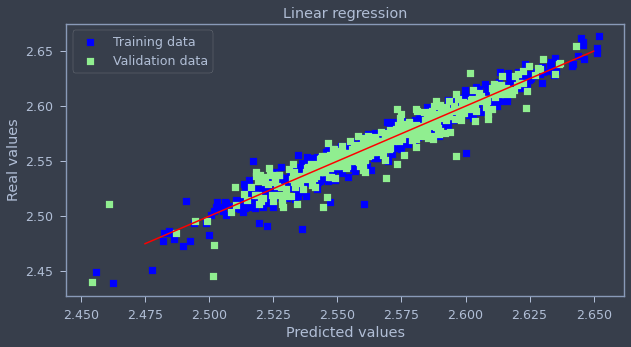

In [28]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 2.475, xmax = 2.65, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([2.475, 2.65], [2.475, 2.65], c = "red")
plt.show()

The RMSE values for the training and test set are abnormally high. However, the errors seem randomly distributed around the centreline, so our model was able to capture most of the explanatory information.

#### 2* Linear Regression with Ridge regularization (L2 penalty)

In this regression we will be adding the squared sum of the weights to our cost function in order to prevent overfitting. 

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 21.0
Ridge RMSE on Training set : 0.008982811359492828
Ridge RMSE on Test set : 0.009111039084097714


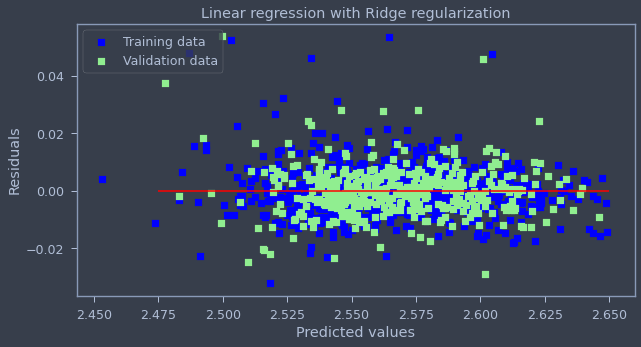

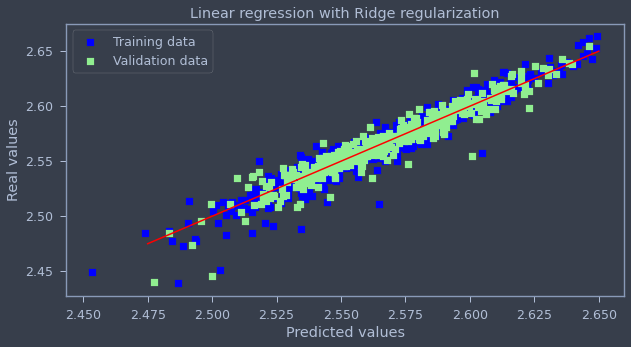

Ridge picked 265 features and eliminated the other 3 features


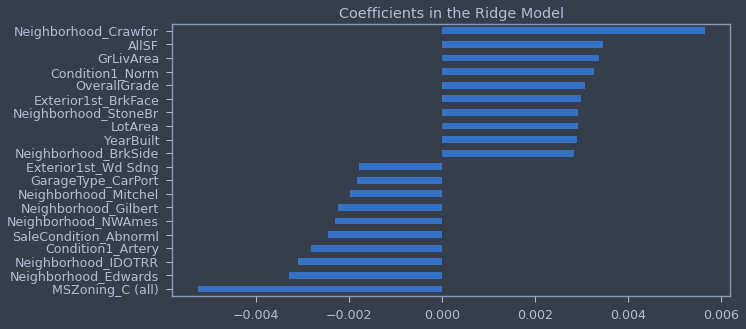

In [29]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 2.475, xmax = 2.65, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([2.475, 2.65], [2.475, 2.65], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

This model gave much better RMSE values for the model. The fact that there is a very small difference between the training RMSE and the test RMSE shows that we have eliminated most of the overfitting.

#### 3* Linear Regression with Lasso regularization (L1 penalty)

LASSO (Least Absolute Shrinkage and Selection Operator) is an alternative regularisation method, that replaces the square of the weights by the sum of the absolute value of the weights. This is useful since we have a dataset with a lot of features and L1 regularisation yields sparse feature vectors, therefore, most feature weights will be 0.

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05
Lasso RMSE on Training set : 0.008846094126551369
Lasso RMSE on Test set : 0.008891779811390292


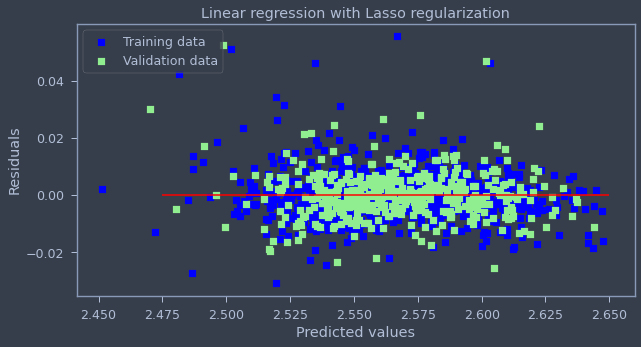

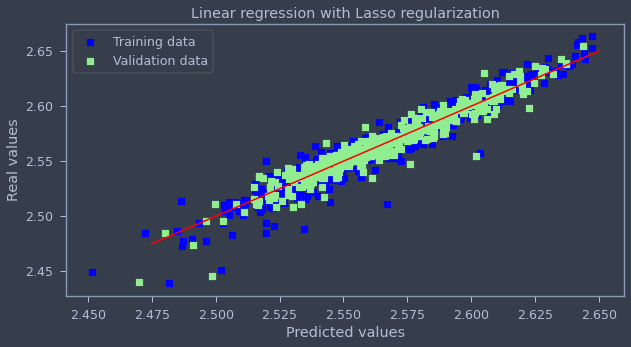

Lasso picked 97 features and eliminated the other 171 features


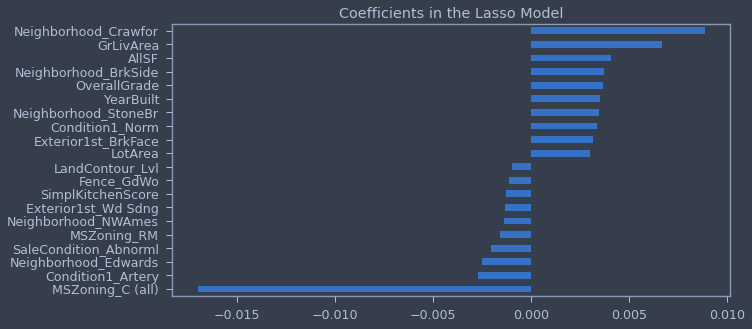

In [31]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 2.475, xmax = 2.65, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([2.475, 2.65], [2.475, 2.65], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

The RMSE for the LASSO regression is similar to the RIDGE above, however the disparity between the train RMSE and the test RMSE has come down. The LASSO only used 36% of the available features. This is interesting since it would seem a lot of the features in the dataset have no effect on the `SalePrice`. We can also see that `Neighbourhood` is given quite large weightings, both positivley and negativley, this was expected from our EDA earlier and intuitivley we know that location plays a large part in the vaue of a house. `MSZoning_C (all)` is given an unusually large negative weighting and is described as *general zoning classification: commercial*, suggesting having a house in a mostly commercial zone reduces the value significantly.

#### 4* Linear Regression with ElasticNet regularization (L1 and L2 penalty)

ElasticNet is a compromise between RIDGE and LASSO. It will generate sparsity through an L1 penalty and overcome the limitations of LASSO through an L2 penalty. 

Best l1_ratio : 0.1
Best alpha : 0.0003
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.11499999999999999
Best alpha : 0.0003
Now try again for more precision on alpha, with l1_ratio fixed at 0.11499999999999999 and alpha centered around 0.0003
Best l1_ratio : 0.11499999999999999
Best alpha : 0.00033
ElasticNet RMSE on Training set : 0.00884793944557084
ElasticNet RMSE on Test set : 0.009072928014122593


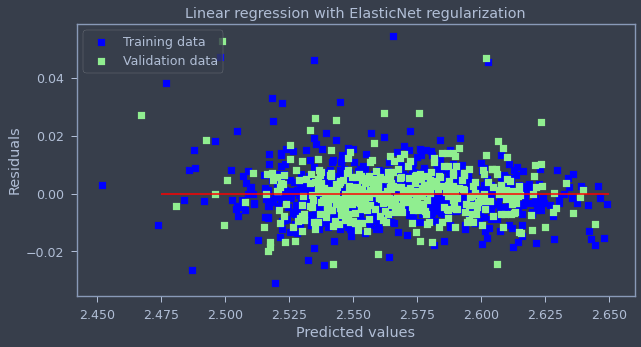

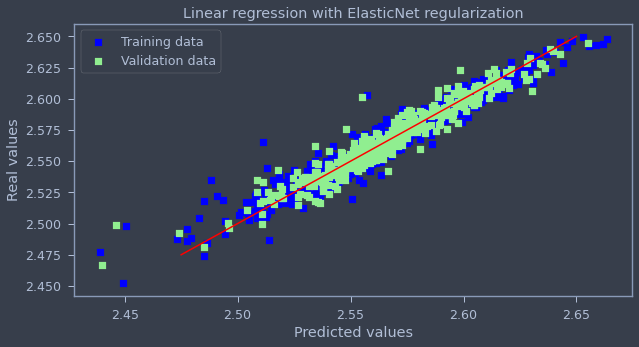

ElasticNet picked 115 features and eliminated the other 153 features


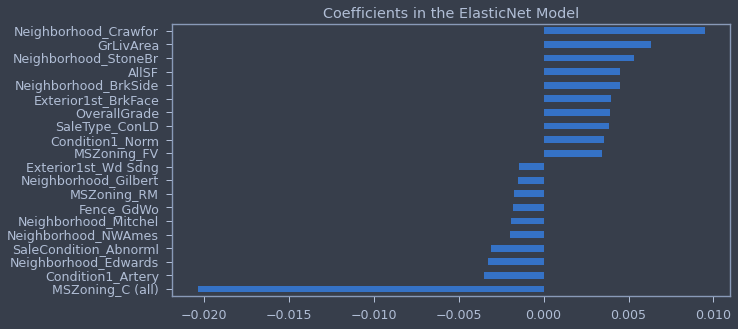

In [33]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 2.475, xmax = 2.65, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([2.475, 2.65], [2.475, 2.65], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

This model has scored a similar RMSE to the LASSO regressor above, so the L2 penalty isn't that effective at improving the performance of this model on this dataset. The number of features used was slightly higher than the LASSO however we can see the same trends with the coefficients used. 

## Conclusion

By taking the time to preprocess the data and optimising the regularisation of the model we have obtained a machine learning algorithm with a good RMSE score for predicting the `SalePrice` of houses. We have seen that `Neighborhood` plays a large part in the prediction of house prices as well as the overall condition of the property. We have also seen that a house located in a commercial setting has large negative impact on the `SalePrice`. 